# Explanatory notebook for morphological indicator assessment

importing packages

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
import scipy.io
import time
import calendar
from datetime import datetime
import urllib
from sklearn.model_selection import train_test_split

Defining steady variables

In [2]:
#Correction between hydrographic 0 and land 0
corr3 = -1.98  # Cap Ferret
#correction niveau moyen en zéro H
nmzh3 = 2.37   # Cap Ferret
g=9.8
densi=1025

## Importing Hydrographic Data

Data are initially .nc files, one per month and per variables (wave heith :Hs, wave period: Tp, and setup). In order not to overload the CPU with excessive loading time through  'urllib.request.urlretrieve', we created a .csv file for the following coordinates
Latitude  : 44.6525
Longitude : -1.45

For wave heith and period:
Data are given by the model Wave Watch III forced by GFS model for winds , 
For water level ( Setup):
Data are given by the model MARS2D.

Both Dataset are given once every 3 hours, at a point located at 12 km offshore the beach where morphological profiles.

Time is given in seconds since Python epoch (01/01/1970).

In [4]:
#import hydro
DF=pd.read_csv('https://raw.githubusercontent.com/env-models/Beach_erosion/master/datasets/Data_frame.csv',delimiter=';')

Hs=DF['hs']
Time_Hs=DF['# time']
Tp=DF['tp']
setup=DF['setup']
print('first date : ',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Time_Hs[0])))
print('last date  : ' ,time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Time_Hs.iloc[-1])))

first date :  2008-01-01 00:00:00
last date  :  2014-12-31 21:00:00


## Importing morphological data.

Beach profiles are made once per 2 weeks, averaged along 500m of coastline. Precision of 10cm

In [5]:
local_filename, headers = urllib.request.urlretrieve(r'https://raw.githubusercontent.com/env-models/Beach_erosion/master/datasets/TrucVert_OCA.mat')
Prof = scipy.io.loadmat(local_filename)
x=Prof['x']
x=x[0,:]
z =Prof['z']

Profil time has to be changed so that it matches hydrological time.

In [6]:
Time_Profil=Prof['date'] #Jours depuis l'an 0
Time_Profil=Time_Profil[0,:]
epoch_matlab= time.strptime("0001-01-01T00:00:00", "%Y-%m-%dT%H:%M:%S")#minus year is 1
epoch_sec=calendar.timegm(epoch_matlab)#secondesde 0 à 1970
var=[X*86400+epoch_sec-365.242*86400-155491 for X in Time_Profil] #adding 1 year here
Time_Profil=var
print('first Profil : ',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Time_Profil[0])))
print('last Profil  : ' ,time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Time_Profil[-1])))


first Profil :  2005-04-08 13:00:00
last Profil  :  2015-06-18 13:00:00


The mean profil of the beach from 2005 to 2015 has a significant importance as it allows us to assess the state of the beach prior to a storm.i.e is it erroded or not.

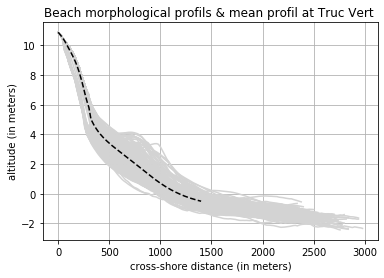

In [7]:
ini=np.searchsorted(Time_Profil,Time_Hs[1],'left')-1
fin=np.searchsorted(Time_Profil,max(Time_Hs),'left')-1
k=range(ini,fin+1)

#Mean Profil: 
Zmoy=[]
for j in range(len(x)):
    Zmoy=np.append(Zmoy,np.mean(z[k,j]))
    
end=min(np.argwhere(np.isnan(Zmoy)))-1
end=int(end)

for i in range(0,len(Time_Profil)):
    plt.plot(z[i,:],'lightgray')
plt.plot(Zmoy,'k--')
plt.xlabel('cross-shore distance (in meters)')
plt.ylabel('altitude (in meters)')
plt.title('Beach morphological profils & mean profil at Truc Vert ')
plt.grid()

plt.show()

## Computing the indicator :
Once  data is loaded and the various times converted, we can iterate over the full period in order to get the value of the runup for every dates in time.
The information about the runup allows us to assess the maximum extension of the water along the coastline, hence evaluating if a morphological threshold is reached por not. This threeshold is then uses as an indicator of wether or not we are in erosive conditions. 

The indicator itself  SCWmS, represents the horizontal distance between the dynamic water level (setup + runup) and the morphological setup.
if SCWmS>0 the threeshold is not reached
if SCWmS<0 the threeshold is reached

[]

<Figure size 850x510 with 0 Axes>

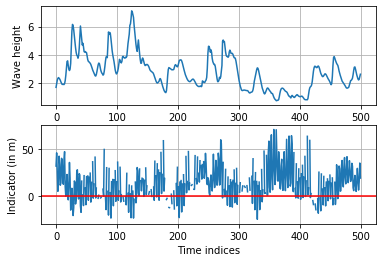

In [8]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

penteS =  [] # Slope
borneinf=[]  # lower point on the beach used to calculate the slope
bornesup=[]  # Upper point on the beach used to calculate the slope
runup=[]     # Wave runup
SCWmS=[]     # Indicator
HoS=[]       # Significativ wave heigh at infinite depth
KsS=[]       # Shoaling Coefficient
Lo_inf=[]    #Swell wavelength at infinite depth

for n in range(len(Hs)):
    ind=np.searchsorted(Time_Profil,Time_Hs[n],'left')-1
    ELE=z[ind,:]
    ELE=ELE[~pd.isnull(ELE)]#Nan off
    DIST=x
    beta = 3#2.14
    Xf=DIST[find_nearest(ELE,beta)]
    
    #  Slope calculation
    if (setup[n])< min(ELE):  #% % pas de calcul de pente si le niveau n'atteint pas la fin du profils ou dépasse la crête
        penteS = np.append(penteS,np.nan)               
    else:
        borneinf = DIST[find_nearest(ELE,setup[n])]
        bornesup = DIST[find_nearest(ELE,4)]
        penteS = np.append(penteS,abs((4-setup[n])/(borneinf-bornesup)))
                
    #  Shoaling coefficient
    Lo_inf=np.append(Lo_inf,(g*Tp[n]**2)/(2*math.pi))
    tempS=2*math.pi*50/Lo_inf[n]
    KsS=np.append(KsS,math.sqrt(1/(math.tanh(tempS)*(1+2*tempS/math.sinh(2*tempS)))))    
    HoS=np.append(HoS,Hs[n]/KsS[n])
    
    #  Final Setup:
    IrrS=penteS[n]/math.sqrt(HoS[n]/Lo_inf[n])
    if pd.isnull(IrrS):
        runup=np.append(runup,np.nan)        
    elif IrrS<0.3:
        runup=np.append(runup,0.043*math.sqrt(HoS[n]*Lo_inf[n]))        
    elif IrrS >=0.3:
        runup=np.append(runup,1.1*(0.35*penteS[n]*math.sqrt(HoS[n]*Lo_inf[n])+0.5*(math.sqrt(HoS[n]*Lo_inf[n]*(0.563*(penteS[n]**2)+0.004)))))

   #  modele-tide+runup 
    waterlvlmomS=setup[n]+runup[n]
    
   #  Indicator
    if np.isnan(waterlvlmomS):
        SCWmS=np.append(SCWmS,np.nan)
    else:
        indicewlmon=DIST[find_nearest(ELE,waterlvlmomS)]
        SCWmS=np.append(SCWmS,indicewlmon-Xf)       
        
#END OF LOOP
#=====plot-test indicator      
i=0
j=i+500
figure(num=None, figsize=(10, 6), dpi=85, facecolor='w', edgecolor='k')
fig, ax = plt.subplots(nrows=2, ncols=1)

plt.subplot(2,1,1)
plt.ylabel('Wave height')
plt.plot(Hs[i:j])
plt.grid()

plt.subplot(2,1,2)
plt.xlabel('Time indices')
plt.ylabel('Indicator (in m)')
plt.plot(SCWmS[i:j])
plt.axhline(y=0,color='red')
plt.grid()
plt.plot()


## Storm selection. 

Based on the bibliography, we are using 2 hydrological threesholds to define storm conditions: 
- The 95% quantile as the storm threshold definition
- the 75% quantile  as the threeshold to define the begining and the ending of the storm.


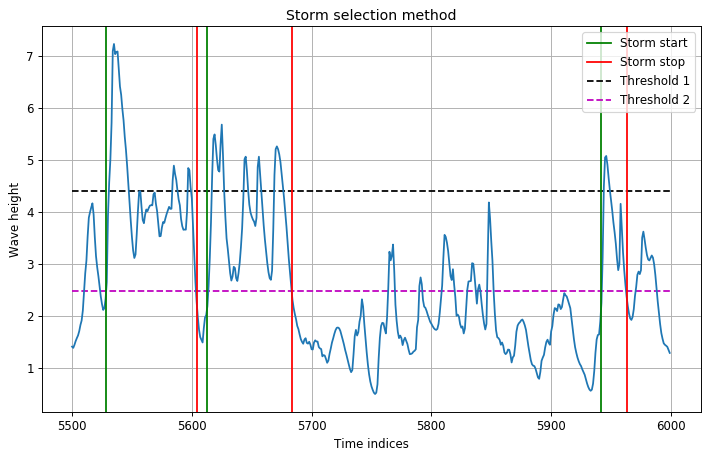

In [10]:

#%%==========Storm selection thresholds=================================
seuil1=np.quantile(Hs,.95)      #Threshold for storm definition
seuil2=np.quantile(Hs,.75);     #Threshold for beginning and ending of the storm

#=================find start and stop of the storm===================
start=[] #indexes for storm starts
stop=[] # indexes for storm endings
ind_last_storm=max([index for index,value in enumerate(Hs) if value < seuil2])
ind_storm = [i for i in range(ind_last_storm) if Hs[i] > seuil1]

for i in ind_storm:
    xxx=[index for index,value in enumerate(Hs[0:i]) if value < seuil2] 
    yyy=[index for index,value in enumerate(Hs[i:-1]) if value < seuil2]
    if xxx:
        start.append(max(xxx))
        stop.append(min(yyy)+i)      
start=sorted(list(set(start)))
stop=sorted(list(set(stop)))

# ======================plot test - storm=================================
i=5500
j=i+500
figure(num=None, figsize=(10, 6), dpi=85, facecolor='w', edgecolor='k')
plt.plot(range(i,j),Hs[i:j])
plt.hlines(seuil1,  i,j, colors='k', linestyles='--',label ='Threshold 1')
plt.hlines(seuil2,  i,j, colors='m', linestyles='--',label ='Threshold 2')
 
for xc in start:
    if xc>i and xc<j:
        plt.axvline(x=xc,color='green',label ='Storm start')
for xc in stop:
        if xc>i and xc<j:
             plt.axvline(x=xc,color='red',label ='Storm stop')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='upper right')

plt.ylabel('Wave height')
plt.xlabel('Time indices')
plt.title ('Storm selection method')
plt.grid()
plt.show()

# Training and testing the indicator

Now we define train and test populations using the ratio 85/15.
Then we assess the erroded volume between 2 profils in m3/m (>0 if actually erroded) and the energy released upon the beach, in MJ/m

<function matplotlib.pyplot.show(*args, **kw)>

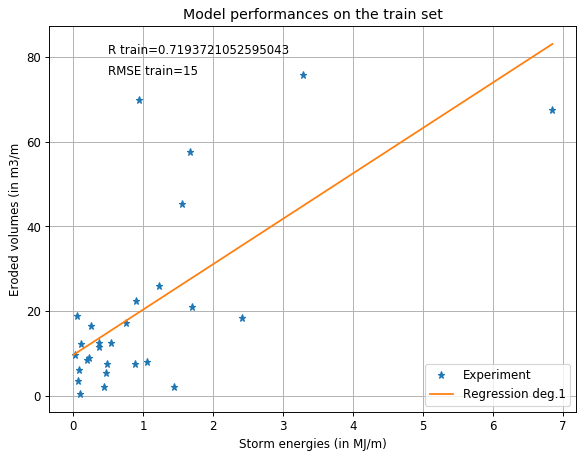

In [11]:

#%%================================== S P L I T ================================
Hs_train, Hs_test=train_test_split(Hs,test_size=0.15, shuffle=False)
Time_train, Time_test=train_test_split(Time_Hs,test_size=0.15, shuffle=False)

#%%==================================T R A I N ========================
Int=[]
V_err=[]
En_sum=[]
En=np.zeros(len(Hs_train))
Hs0=np.zeros(len(Hs_train))

for i in range(0,len(start)):
        if stop[i]<len(Hs_train):
            Hs0[start[i]:stop[i]]=Hs[start[i]:stop[i]]

ind = [i for i in range(len(Hs_train)) if SCWmS[i]<0] #Energy only when the indicator is reached
En[ind]=(1/16*densi*g*(Hs0[ind]**2))*3

ini=np.searchsorted(Time_Profil,min(Time_train))
fin=np.searchsorted(Time_Profil,max(Time_train))-1 

for i in range(ini,fin-1):
    ti=np.searchsorted(Time_train,Time_Profil[i])
    tf=np.searchsorted(Time_train,Time_Profil[i+1])
    En_sum=np.append(En_sum,sum(En[ti:tf]))
    
En_sum=En_sum/1000000 # from J to MJ

#==============Volumes=========
for i in range(ini,fin):
    Int=np.append(Int,np.trapz(z[i,0:end],x[0:end]))
for i in range(0,len(Int)-1):
    V_err=np.append(V_err,Int[i]-Int[i+1])   

#deleting values
#when Energy=0        
ind = [i for i in range(0,len(En_sum)) if En_sum[i] ==0]     
En_sum=np.delete(En_sum,ind)
V_err=np.delete(V_err,ind)

#When the beach has not been eroded (Verr <0)
ind2=[i for i in range(0,len(En_sum)) if V_err[i] <0]   
En_sum=np.delete(En_sum,ind2)
V_err=np.delete(V_err,ind2)

#=====Statistics===========
r=np.polyfit(En_sum,V_err,1)
r2=np.polyfit(En_sum,V_err,2)
i=V_err
j=En_sum*r[0]+r[1]
k=r2[0]*(En_sum**2)+r2[1]*En_sum+r2[2]
#R
R_train=np.corrcoef(i,k)[1,0]
#RMSE
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(i, j))

#storing regression parameters
COEFF_Mod1=r
COEFF_Mod2=r2

#Train_set plot
figure(num=None, figsize=(8, 6), dpi=85, facecolor='w', edgecolor='k')
xx=np.linspace(0,max(En_sum),100)
plt.plot(En_sum, V_err,'*',label='Experiment')
plt.plot(xx, xx*r[0]+r[1],label='Regression deg.1')
plt.xlabel('Storm energies (in MJ/m)')
plt.ylabel('Eroded volumes (in m3/m')
plt.title('Model performances on the train set')
plt.grid()
plt.legend(loc='lower right')
plt.text(0.5,max(V_err),'RMSE train='+str(int(rmse)),fontsize=10)
plt.text(0.5,max(V_err)+5,'R train='+str(R_train),fontsize=10)
plt.show


C:\Users\sound\Documents\Conda\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


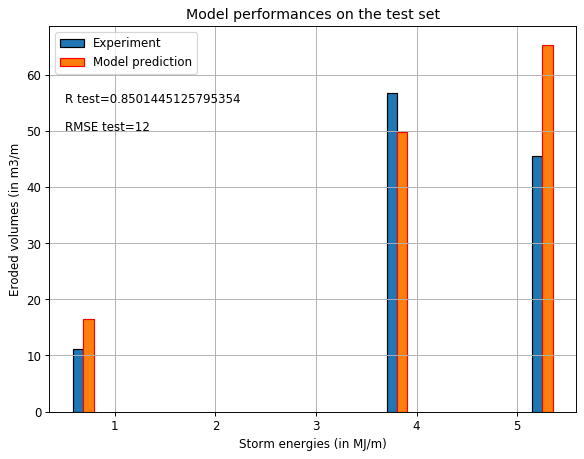

In [12]:
#%%==================================#==================================
#================================== T E S T ========================
Int=[]
V_err=[]
Hs0=np.zeros((len(Hs)))
En=[]
En_sum=[]

xi=np.searchsorted(start,len(Hs_train))
for i in range(xi,len(start)):
            Hs0[start[i]:stop[i]]=Hs[start[i]:stop[i]]
            
ind = [i for i in range(len(Hs_train),len(Hs)) if SCWmS[i]<0] 
for i in ind:
    En=np.append(En,(1/16*densi*g*(Hs0[i]**2))*3)

ini=np.searchsorted(Time_Profil,min(Time_test))
fin=np.searchsorted(Time_Profil,max(Time_test))-1 # not to run out oh HS

for i in range(ini,fin):
    ti=np.searchsorted(Time_test,Time_Profil[i])
    tf=np.searchsorted(Time_test,Time_Profil[i+1])
    En_sum=np.append(En_sum,sum(En[ti:tf]))
    
En_sum=En_sum/1000000 #passage de J à MJ

#Volumes

for i in range(ini,fin):
    Int=np.append(Int,np.trapz(z[i,0:end],x[0:end]))

for i in range(0,len(Int)-1):
    V_err=np.append(V_err,Int[i]-Int[i+1])
    
ind = [i for i in range(0,len(En_sum)) if En_sum[i] ==0]     
En_sum=np.delete(En_sum,ind)
V_err=np.delete(V_err,ind)

ind2=[i for i in range(0,len(En_sum)) if V_err[i] <0]   
En_sum=np.delete(En_sum,ind2)
V_err=np.delete(V_err,ind2)

#Statistics
i=V_err
j=En_sum*r[0]+r[1]
k=r2[0]*(En_sum**2)+r2[1]*En_sum+r2[2]
#R
R_test=np.corrcoef(i,j)[1,0]

#RMSE
from sklearn.metrics import mean_squared_error
rms = math.sqrt(mean_squared_error(i, j))


#====Final Plot==========

#plt.bar
figure(num=None, figsize=(8, 6), dpi=85, facecolor='w', edgecolor='k')
plt.bar(En_sum,V_err, width=0.1,edgecolor='k', label='Experiment')
plt.bar(En_sum+0.1, En_sum*r[0]+r[1], width=0.1,edgecolor='r', label='Model prediction')
plt.legend()
plt.xlabel('Storm energies in MJ/m')
plt.ylabel('Erroded volumes in m3')
plt.grid()
plt.xlabel('Storm energies (in MJ/m)')
plt.ylabel('Eroded volumes (in m3/m')
plt.title('Model performances on the test set')
plt.text(0.5,50,'RMSE test='+str(int(rms)),fontsize=10)
plt.text(0.5,55,'R test='+str(R_test),fontsize=10)
plt.show()

#END PLOT##


# Discussion

There is definitly a correlation between the energy of storms and the erosion processes. Nevertheless, noise is too important, particularly at low level energy. Considering only erosive events(storms with Volume>0) lowered this noise, though it remains too influent.

Various elements should be implemented in order to improve model predictions. 

    - First fitting a more complex function assessing the non linear behaviour of the beach response.
    - Using the prior state of the beach (erroded or not) as a classifier. 
    - Results differ when the test set size is modified, hence some parts of the script are obviously miscoded.
    - Considering storm clusters (storms following each others) may improve results.